In [21]:
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if os.path.isdir(os.path.join(PROJECT_ROOT, "src")):
    sys.path.insert(0, PROJECT_ROOT)
else:
    # fallback: try current directory
    sys.path.insert(0, os.getcwd())

import matplotlib.pyplot as plt
import copy
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D

from src.solver_utils import solve_precond
from src.basis.basis import BasisHandler
from src.matrix_generation import assemble_matrix_integral_1d
from src.primitives import Primitives_MinimalSupport
from src.operators import differentiate

In [5]:
#Benchamrk solution
u_exact = lambda x, y: np.sin(np.pi * x) * np.sin(np.pi * y)
u_exact_x = lambda x, y: np.pi * np.cos(np.pi * x) * np.sin(np.pi * y)
u_exact_y = lambda x, y: np.pi * np.sin(np.pi * x) * np.cos(np.pi * y)
f_rhs = lambda x, y: 2 * (np.pi ** 2) * np.sin(np.pi * x) * np.sin(np.pi * y)

In [6]:
#Basis construction
primitives = Primitives_MinimalSupport()
basis_handler = BasisHandler(primitives=primitives, dimension=1)

In [23]:
def test_2d(
    levels,
    u_exact,
    u_exact_x,
    u_exact_y,
    f_rhs,
    xs_ref=np.linspace(0, 1, 100),
    ys_ref=np.linspace(0, 1, 100),
):
    """
    Run convergence study for the 2D Poisson wavelet–Galerkin solver (isotropic tensor).

    Parameters
    ----------
    levels : list[int]
        Refinement levels (values of J_max).
    u_exact : callable
        Exact solution u(x,y).
    u_exact_x, u_exact_y : callable
        Exact partial derivatives of u.
    f_rhs : callable
        Right-hand side f(x,y).
    xs_ref, ys_ref : np.ndarray
        Evaluation grid for error computation.

    Returns
    -------
    errors_H1, errors_L2 : list[float]
    Ss : list[np.ndarray]
        Assembled stiffness matrices at each level.
    Ns : list[int]
        Number of basis functions per level.
    U_solutions : list[np.ndarray]
        Numerical solution values u_num(x,y) on the grid for each level.
    """
    X, Y = np.meshgrid(xs_ref, ys_ref, indexing="ij")
    u_ref = u_exact(X, Y)
    u_ref_x = u_exact_x(X, Y)
    u_ref_y = u_exact_y(X, Y)

    errors_L2, errors_H1, Ns, Ss, U_solutions = [], [], [], [], []

    for Jmax in levels:
        print(f"\n=== Testing level {Jmax} ===")

        # ---- build 1D bases ----
        basis_handler.build_basis(J_Max=Jmax, comp_call=True, J_0=2)
        basis_handler_diff = copy.deepcopy(basis_handler)
        basis_handler_diff.apply(differentiate, comp_call=True, axis=0)

        # ---- assemble 1D and 2D matrices ----
        M1 = assemble_matrix_integral_1d(
            basis_handler.flatten(), basis_handler.flatten()
        )
        S1 = assemble_matrix_integral_1d(
            basis_handler_diff.flatten(), basis_handler_diff.flatten()
        )
        from src.matrix_generation import extend_stiffness, extend_mass
        S2 = extend_stiffness(M1, S1, 2)
        Ss.append(S2)

        # ---- project RHS and solve ----
        b2 = basis_handler.project_rhs_2d_gauss(f_rhs)
        coeffs = solve_precond(S2, b2)

        # ---- evaluate numerical solution ----
        u_num = basis_handler.evaluate_solution_2d_kron(coeffs, xs_ref, ys_ref)   
        U_solutions.append(u_num)
        
        u_num_x = basis_handler_diff.evaluate_solution_2d_kron(coeffs, xs_ref, ys_ref)

        # ---- compute L2 and H1 errors ----
        err_L2 = np.sqrt(np.trapezoid(
            np.trapezoid((u_num - u_ref) ** 2, ys_ref, axis=1), xs_ref
        ))
        # grad_err = (u_num_x - u_ref_x) ** 2
        err_H1 = 0 # Not implemented 

        print(f"L2 error = {err_L2:.3e},   H1 error = {err_H1:.3e}")

        errors_L2.append(err_L2)
        errors_H1.append(err_H1)
        Ns.append(len(basis_handler.flatten()) ** 2)

    return errors_H1, errors_L2, Ss, Ns, U_solutions

       

In [24]:
levels=[2,3,4]
errors_H1, errors_L2, Ss, Ns, U_solutions=test_2d(levels,u_exact,u_exact_x,u_exact_y,f_rhs,)


=== Testing level 2 ===
3
L2 error = 2.568e-04,   H1 error = 0.000e+00

=== Testing level 3 ===
4
L2 error = 3.111e-05,   H1 error = 0.000e+00

=== Testing level 4 ===


/Users/rados/Projects_personal/Galerkin_solver3/src/matrix_generation.py:30: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  val, _ = quad(lambda x: fi(x) * fj(x), a, b, epsabs=1e-12, epsrel=1e-12)


5
L2 error = 3.858e-06,   H1 error = 0.000e+00


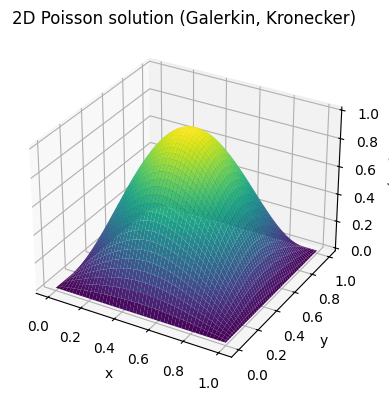

In [25]:
U_num=U_solutions[-1]
xs = np.linspace(0, 1, U_num.shape[0])
ys = np.linspace(0, 1, U_num.shape[1])
X, Y = np.meshgrid(xs, ys, indexing="ij")

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, U_num, cmap="viridis", linewidth=0, antialiased=True)
ax.set_title("2D Poisson solution (Galerkin, Kronecker)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u(x,y)")
plt.tight_layout()
plt.show()



Matrix size: 1024 × 1024
Original:  204160 nonzeros  (19.47% dense)
Thresholded (|S| ≥ 1e-06):  191100 nonzeros  (18.22% dense)


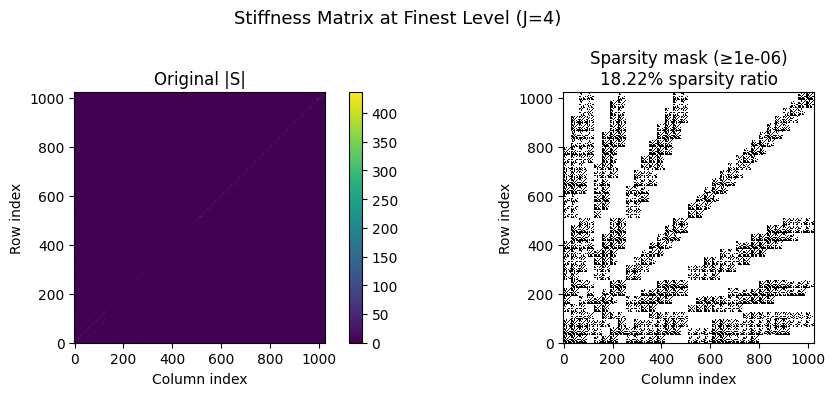

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# take the last (finest) stiffness matrix
S_last = Ss[-1]

# threshold value (tune as needed)
threshold = 1e-6

# absolute-value version and binary mask
S_abs = np.abs(S_last)
S_mask = (S_abs >= threshold).astype(float)

# compute sparsity statistics
n_total = S_last.size
n_nz_orig = np.count_nonzero(S_abs)
n_nz_mask = np.count_nonzero(S_mask)

ratio_orig = 100 * n_nz_orig / n_total
ratio_mask = 100 * n_nz_mask / n_total

print(f"Matrix size: {S_last.shape[0]} × {S_last.shape[1]}")
print(f"Original:  {n_nz_orig} nonzeros  ({ratio_orig:.2f}% dense)")
print(f"Thresholded (|S| ≥ {threshold:g}):  {n_nz_mask} nonzeros  ({ratio_mask:.2f}% dense)")

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# left: original absolute matrix
im0 = axes[0].imshow(S_abs, cmap="viridis", origin="lower")
axes[0].set_title(f"Original |S|")
axes[0].set_xlabel("Column index")
axes[0].set_ylabel("Row index")
fig.colorbar(im0, ax=axes[0], fraction=0.046)

# right: thresholded binary sparsity pattern
im1 = axes[1].imshow(S_mask, cmap="gray_r", origin="lower", interpolation="none")
axes[1].set_title(f"Sparsity mask (≥{threshold:g})\n{ratio_mask:.2f}% sparsity ratio")
axes[1].set_xlabel("Column index")
axes[1].set_ylabel("Row index")

plt.suptitle(f"Stiffness Matrix at Finest Level (J={levels[-1]})", fontsize=13)
plt.tight_layout()
plt.show()

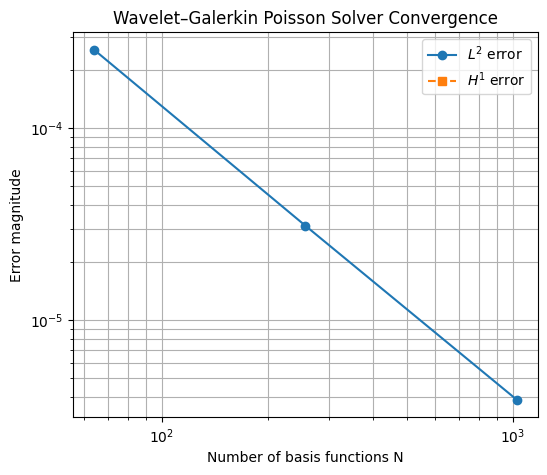

In [27]:
plt.figure(figsize=(6,5))
plt.loglog(Ns, errors_L2, 'o-', label=r'$L^2$ error')
plt.loglog(Ns, errors_H1, 's--', label=r'$H^1$ error')
plt.xlabel("Number of basis functions N")
plt.ylabel("Error magnitude")
plt.title("Wavelet–Galerkin Poisson Solver Convergence")
plt.grid(True, which="both")
plt.legend()
plt.show()